# Selecting model

## Homebrew Convolutional Neural Network

In [1]:
from hyper_tuning_helper_functions import model_cnn_2_classes, show_classification_evaluation_metrics
from load_datasets import create_generators, extract_feature_maps

In [10]:
train_generator_64x64, X_test_64x64, y_test_64x64 = create_generators(
    (64, 64), just_train_generator=True
)


cat_dog_32x32_image_model = model_cnn_2_classes(
    [32, 64, 128, 128], [(512, 0)], name="model_1", input_shape=(64, 64, 3)
)


cat_dog_32x32_image_model.fit(
    train_generator_64x64,
    steps_per_epoch=50,
    epochs=137,
    verbose=0,
)

2022-05-12 15:43:00.629394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-05-12 15:44:39.318403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.64      0.73      0.68       433
           1       0.77      0.68      0.72       567

    accuracy                           0.70      1000
   macro avg       0.70      0.71      0.70      1000
weighted avg       0.71      0.70      0.70      1000



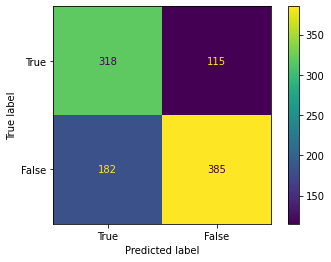

In [11]:
y_pred_64x64 = cat_dog_32x32_image_model.predict(X_test_64x64)
y_pred_64x64 = (y_pred_64x64 > .5) * 1

show_classification_evaluation_metrics(y_test_64x64, y_pred_64x64)

## Xception with Random Forest Classifier

### Feature Extraction

In [2]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.ensemble import RandomForestClassifier

image_size = 299

cat_dog_299x299_feature_extractor = Sequential(
    [
        Xception(
            weights="imagenet",
            include_top=False,
            input_shape=(image_size, image_size, 3),
        ),
        GlobalAveragePooling2D(),
    ]
)

train_generator_299x299, X_test_299x299, y_test_299x299 = create_generators(
    (image_size, image_size), just_train_generator=True
)

X_train_299x299, y_train_299x299 = extract_feature_maps(
    cat_dog_299x299_feature_extractor, train_generator_299x299
)

X_test_feature_mapped = cat_dog_299x299_feature_extractor.predict(X_test_299x299)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-12 17:02:37.859722: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-12 17:02:37.859816: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-12 17:02:56.898225: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-12 17:02:57.118526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 17:03:26.593176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Prediction

In [9]:
cat_dog_299x299_image_model = RandomForestClassifier()
cat_dog_299x299_image_model.fit(X_train_299x299, y_train_299x299)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       494
           1       1.00      0.99      0.99       506

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



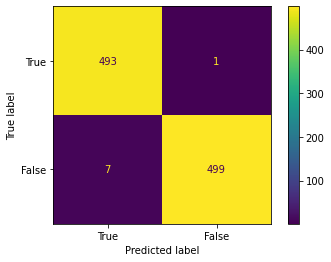

In [10]:
y_pred_299x299 = cat_dog_299x299_image_model.predict(X_test_feature_mapped)

show_classification_evaluation_metrics(y_test_299x299, y_pred_299x299)

## Misclassified images

IndexError: index 8 is out of bounds for axis 0 with size 8

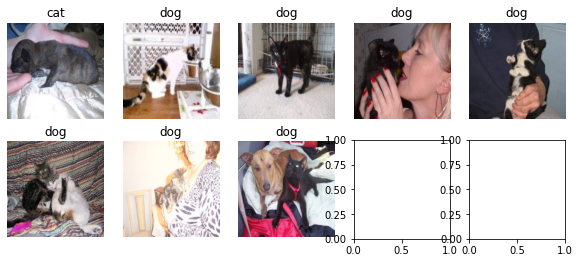

In [11]:
from helper_functions import plot_sample_images
import numpy as np

misclassified_indices = np.where(y_pred_299x299 != y_test_299x299)
misclassified_samples = X_test_299x299[misclassified_indices]
misclassified_labels = y_pred_299x299[misclassified_indices]

plot_sample_images((misclassified_samples, misclassified_labels), labels=False, labels_v2=True);